In [1]:
import numpy as np
import pandas as pd
import re

import nltk
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns
#import pickle

#nltk.download('punkt')
#nltk.download('stopwords')

In [2]:
lemmatizer = WordNetLemmatizer()
stopWords = set(list(stopwords.words("english")) + ['work', 'environment', 'etc', 'also', 'application', 'click', 'e.g', 'opportunity', '\'ll', '\'re', '\'s', ',', '!', '.', ':', ';',]) 

# Lemma, filter out stopwords. 
def text2LemmaNoStops(text):
    tokens = word_tokenize(text.lower())
    filteredTokens = [lemmatizer.lemmatize(token, "n") for token in tokens if token not in stopWords]
    return " ".join(filteredTokens)

# Ensures the tokens are unique, and sorts the tokens from A-Z. 
def text2Unique(text):
    tokens = word_tokenize(text)
    uniqueTokens = sorted(set(tokens))
    return " ".join(uniqueTokens)

# Takes a list and counts the tokens
# Returns a frequency df with the tokens
def countTokens(textList):
    c = Counter()
    for row in textList:
        c.update(word_tokenize(row))
    return pd.DataFrame(c.items(), columns=['Keyword', 'Frequency']).sort_values(by='Frequency', ascending=False, ignore_index=True)

# Used to cross reference jobDescriptions with key tokens or phrases
def crossRef(columnList, labelList):
    labelSet = set(labelList)
    intersection = [" ".join([token for token in word_tokenize(row) if token in labelSet]) for row in columnList]
    return intersection

In [3]:
df = pd.read_csv('dfSummary.csv', engine='python').loc[:,['jobTitle', 'descriptionShort', ]] # 'description summary'

# Descriptions with no stopwords and lemmatized 
jobDescribe = df['descriptionShort'].apply(text2LemmaNoStops)

# Description with only unique tokens
jobDescribeUnique = jobDescribe.apply(text2Unique)


# The commented-out-variables (below) were put into the model for testing, but were eventually excluded due to unsatisfactory results.

# These generated topics were nonsensical or overly random. For instance, one topic listed "tesla" as the first word among 13, but a search in my dataframe showed only 3 jobs mentioned Tesla, making "tesla" an inaccurate descriptor for that group.
# df['description NoStops'] = jobDescribe.copy()

# This generated a few extremely broad topics. 
# df['summary NoStops'] = df['description summary'].apply(text2LemmaNoStops)

In [4]:
# Identify most frequent tokens. 
# This has at most one per jobDescription
tokensGeneral = countTokens(jobDescribeUnique)

# Words must be in more than 10 of the job descriptions. 
tokensGeneral = tokensGeneral[(tokensGeneral['Frequency'] > 10)].reset_index(drop=True)

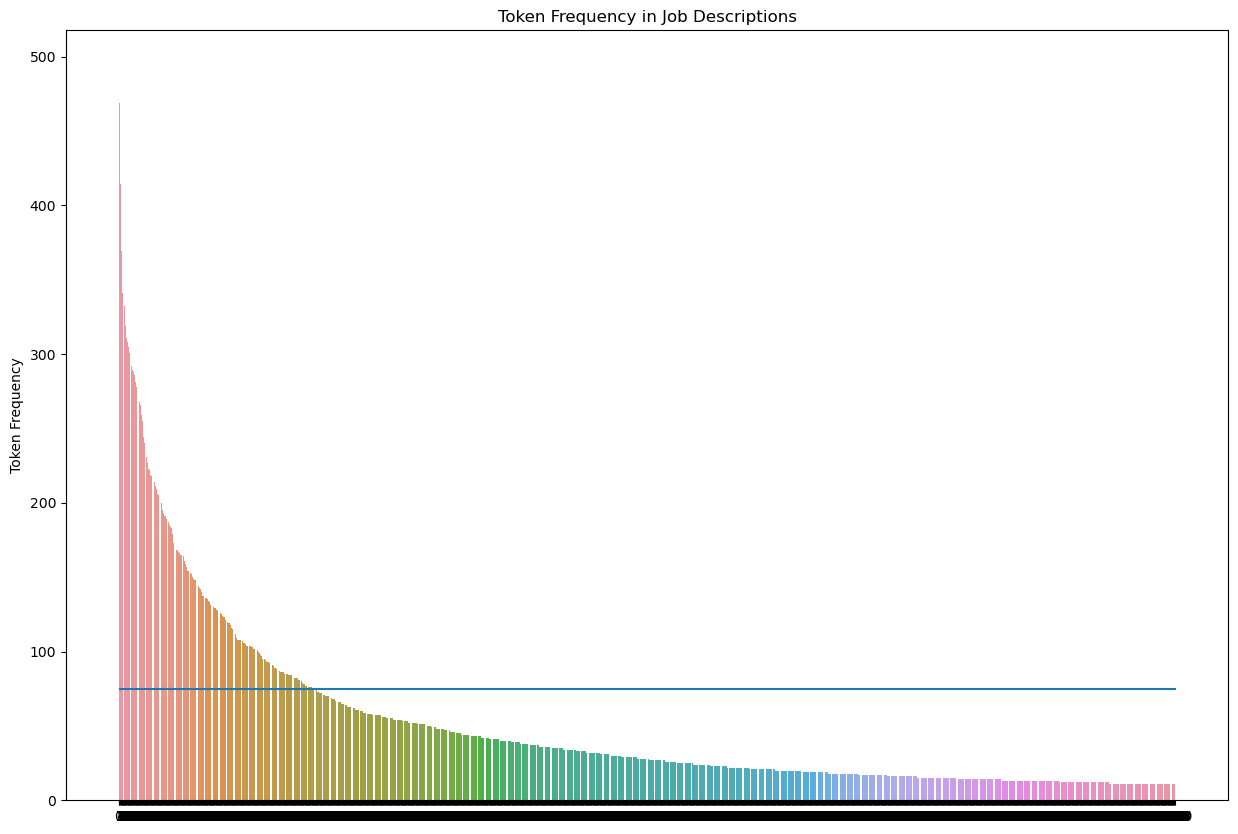

In [5]:
# Plot token frequency
fig, ax = plt.subplots(figsize=(15,10))

X = tokensGeneral.index
Y = tokensGeneral['Frequency'].sort_values(ascending=False)

sns.barplot(x=X, y=Y, ax=ax)

plt.hlines(y=75, xmin=0, xmax=len(X))
plt.ylabel('Token Frequency')
plt.title('Token Frequency in Job Descriptions')
plt.show()


In [6]:
# Used above to determine the cutoff for the most frequent tokens 
tokensFreq = tokensGeneral[tokensGeneral['Frequency'] > 74]['Keyword'].tolist()

In [7]:
# Created new columns by cross referencing jobDescribe with the technology list and keyword list
# Lemmatized tokens before import.
tokensTech = pd.read_csv('listTechnology.csv', engine='python')['Technology'].dropna().to_list()
df['Tech Stack'] = crossRef(jobDescribeUnique, tokensTech)

# This list began as a LinkedIn post about common data science topics and evolved extensively by adding topics from model iterations. It is now unrecognizable from the original source.
tokensKeywords = pd.read_csv('listKeywords.csv', engine='python')['Keyword'].to_list()
df['Key Phrases'] = crossRef(jobDescribe, tokensKeywords)

#Note: When running the model with both unique and repeated tokens, the model consistently generated more categories with greater detail using repeated tokens. This suggests that the model derived the most benefit from the density of repeated tokens.

In [8]:
# Created new column with the frequent, technology, and keyword tokens.  
tokensBOWs = sorted(set(tokensFreq + tokensTech + tokensKeywords))
df['Bag of Words'] = crossRef(jobDescribe, tokensBOWs)

In [9]:
df.replace('', np.NaN, inplace=True)
df.to_csv('dfPreprocessed.csv', index=False)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 507 entries, 0 to 506
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   jobTitle          506 non-null    object
 1   descriptionShort  507 non-null    object
 2   Tech Stack        382 non-null    object
 3   Key Phrases       507 non-null    object
 4   Bag of Words      507 non-null    object
dtypes: object(5)
memory usage: 19.9+ KB


In [11]:
df.nunique()

jobTitle            318
descriptionShort    506
Tech Stack          254
Key Phrases         503
Bag of Words        506
dtype: int64

In [12]:
df.columns

Index(['jobTitle', 'descriptionShort', 'Tech Stack', 'Key Phrases',
       'Bag of Words'],
      dtype='object')

In [13]:
df

,jobTitle,descriptionShort,Tech Stack,Key Phrases,Bag of Words
0,Senior Scientist,"At Element Biosciences, we are passionate abou...",NaN,community scientist biochemistry molecular bio...,passionate mission scientific community impact...
1,Data Scientist Finance,About Us: Live experiences help people cross t...,python sql,digital world life data-driven data operation ...,u experience help people digital focus u new u...
2,Air Quality Modeling Scientist,PSE Healthy Energy is seeking a full-time air ...,github python r,energy scientist scientist scientist energy he...,energy seeking quality modeling scientist assi...
3,Data Scientist,We are interested in every qualified candidate...,python r sql,time data scientist develop model time analysi...,every candidate able take time role analyst da...
4,Marketing Data Research Specialist,Company Overview AdCellerant is an award-winni...,tableau,service digital sale software data research an...,company service company digital marketing solu...
...,...,...,...,...,...
502,Data Scientist,This is a based position. All of the programs ...,airflow aws azure gcp hadoop pipeline powerbi ...,distributed data system development range edge...,based position program support must within bus...
503,Applied Scientist Machine Learning,We are looking for experienced and accomplishe...,java python r,applied scientist machine learning ml research...,looking applied scientist machine learning ml ...
504,Data Science and Machine Learning Matching Spe...,About Andela Andela exists to connect brillian...,NaN,future world network innovation growth growth ...,global future organization around world compan...
505,Data Scientist REMOTE,PTP is a fast-growing system integrator that o...,aws python sql tableau,system strategic data scientist machine learni...,system offer strategic customer experience sol...
